In [1]:
import pandas as pd
import mlflow
import os
import sys
import mlflow.sklearn
from pycaret.classification import *

# Introduction
Below codes will meet the wheat seeds business objective by training a classification model to predict the type of wheat based on kernel attributes.<br>
Evaluating the model using key performance metrics and <br>
Logging the model and experiment details in mlflow for future references and reproducibity

## Configure mlflow for remote experiment tracking
The experiment name created to organize different model run would be 'wheat_classification'<br>
In here , i have set the mlflow tracking uri to make sure that the mlflow tracking server is running.

In [2]:
mlflow.set_tracking_uri("http://localhost:5000")
# Create MLflow Experiment
experiment_name = "wheat_classification"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/511741200058060408', creation_time=1739778668619, experiment_id='511741200058060408', last_update_time=1739778668619, lifecycle_stage='active', name='wheat_classification', tags={}>

## Load dataset
Added codes to ensure that the dataset file exists before going on <br>
The dataset path would be 03_Wheat_Seeds.csv

In [3]:
dataset_path = "03_Wheat_Seeds.csv"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset file '{dataset_path}' not found.")

df = pd.read_csv(dataset_path)

## Pycaret setup
- Scales numerical features
- selects the most important features
- bins continuous numerical variables into intervals for feature engineering
- auto logging is disabled as mlflow logging will be handled manually later ( something is wrong with my version)
- This code target variable is 'type' which represents the 3 wheat varieties.
- Applied normalization to numeric features
- Set up random seed for reproducibility to be 42

In [4]:
clf_setup = setup(
    data=df,
    target="Type",
    normalize=True,            
    feature_selection=True,    
    bin_numeric_features=["Area", "Perimeter", "Length", "Width", "Groove"],  
    session_id=42,
    log_experiment=False, #manually adding the experiment later on in the codes, cannot set this as true as it will show error on my end. perhaps some version/conflicts issue.
)


,Description,Value
0,Session id,42
1,Target,Type
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2"
4,Original data shape,"(199, 8)"
5,Transformed data shape,"(199, 2)"
6,Transformed train set shape,"(139, 2)"
7,Transformed test set shape,"(60, 2)"
8,Numeric features,7
9,Preprocess,True


## Model training and selection
Selects the best model using accuracy as the metric and compare different models
- Uses cross validation to evaluate on each model

In [5]:
best_model = compare_models(sort="Accuracy")


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5676,0.7605,0.5676,0.5854,0.5560,0.3521,0.3645,0.0660
qda,Quadratic Discriminant Analysis,0.5676,0.0000,0.5676,0.5854,0.5560,0.3521,0.3645,0.0720
ridge,Ridge Classifier,0.5670,0.0000,0.5670,0.4669,0.4789,0.3539,0.4110,0.0620
lr,Logistic Regression,0.5604,0.0000,0.5604,0.5763,0.5490,0.3420,0.3537,0.7380
lda,Linear Discriminant Analysis,0.5604,0.0000,0.5604,0.5759,0.5504,0.3407,0.3507,0.1330
ada,Ada Boost Classifier,0.4813,0.0000,0.4813,0.5012,0.4594,0.2252,0.2360,0.0980
dt,Decision Tree Classifier,0.4747,0.6030,0.4747,0.4906,0.4621,0.2120,0.2216,0.0630
rf,Random Forest Classifier,0.4747,0.6598,0.4747,0.4906,0.4621,0.2120,0.2216,0.1250
gbc,Gradient Boosting Classifier,0.4747,0.0000,0.4747,0.4896,0.4622,0.2120,0.2212,0.1610
et,Extra Trees Classifier,0.4676,0.6553,0.4676,0.4775,0.4542,0.2017,0.2106,0.1680


## Model evaluation
- Evaluate the best model performance using the evaluate_model function
- Generates confusion matrix and roc-auc to see whats in the data
- Plots feature importance to see which feature is important.

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

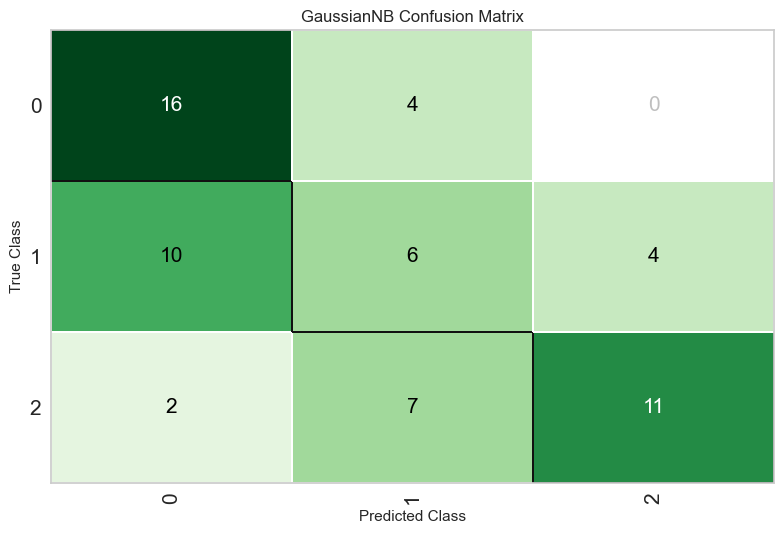

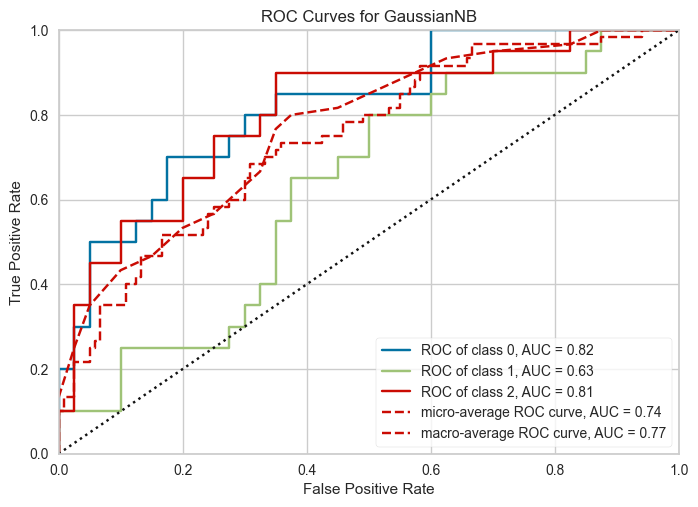

Feature Importance plot skipped as model does not support it.


In [6]:
evaluate_model(best_model) #provides an interactive ui with multiple evaluation metrics

#generate a few plots to see the model performance analysis manually
plot_model(best_model, plot="confusion_matrix") #confusion matrix
plot_model(best_model, plot="auc") #auc roc curve for classificaiton performance.

# Plot feature importance only if the selected model supports it
if hasattr(best_model, "coef_") or hasattr(best_model, "feature_importances_"):
    plot_model(best_model, plot="feature")
else:
    print("Feature Importance plot skipped as model does not support it.")


## Generate predictions on test data
- Generates prediction on unseen data to test model generalization

In [7]:
predictions = predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.5500,0.7521,0.5500,0.5526,0.5399,0.3250,0.3318


## mlflow
- Start mlflow and save the models hyperparameters
- Retrieve the log performance metrics  , save and register model in mlflow
- Added codes to handle error

In [8]:
with mlflow.start_run(run_name="wheat_experiment_run") as run:
    try:
        # Log model's parameters
        mlflow.log_params(best_model.get_params())

        # Get and log performance metrics
        metrics = pull()
        if not metrics.empty:
            numeric_metrics = metrics.select_dtypes(include=['number']).iloc[0].to_dict()
            mlflow.log_metrics(numeric_metrics)

        # define model artiface name in mlflow
        model_artifact_path = "wheat_model"
        model_uri = f"runs:/{run.info.run_id}/{model_artifact_path}"

        # finalized the best model which will retrain the full dataset
        final_model = finalize_model(best_model)
        #log the final model in mlflow , stored in mlflow.
        mlflow.sklearn.log_model(final_model, artifact_path=model_artifact_path)

        # Register Model in MLflow Model Registry
        registered_model = mlflow.register_model(
            model_uri=model_uri,  
            name=model_name
        )

        # log model registry details for tracking 
        mlflow.log_param("registered_model_name", model_name)
        mlflow.log_param("registered_model_version", registered_model.version)

        print(f"Model registered in MLflow as version {registered_model.version}")

    except Exception as e:
        print(f"Error occurred during MLflow logging: {e}")

2025/02/17 16:09:12 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2025/02/17 16:09:23 WARNING mlflow.models.model: Model logged without a signature and input example. Ple

Error occurred during MLflow logging: name 'model_name' is not defined
🏃 View run wheat_experiment_run at: http://localhost:5000/#/experiments/511741200058060408/runs/ccaf075d5aed4386980656c1bdf6ce27
🧪 View experiment at: http://localhost:5000/#/experiments/511741200058060408


## saving model for task 3 usage

In [10]:
save_model(final_model, 'final_wheat_seeds_model')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Area', 'Perimeter', 'Compactness',
                                              'Length', 'Width',
                                              'AsymmetryCoeff', 'Groove'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_va...
                                                                                          min_child_weight=0.001,
                                                                                          min_split_gain=0.0,
  